In [1]:
import pickle as pk
import tensorflow as tf
import numpy as np
#from matplotlib import pyplot as plt
#from pixell import enmap
from tensorflow.keras import datasets, layers, models
from astropy.nddata import block_reduce
from astropy.convolution import Gaussian2DKernel, convolve
#from sklearn.metrics import confusion_matrix
from tensorflow.keras import regularizers
import h5py
from astropy.io import fits
import os
from utils import normalize_map, make_model

#This causes packages to be automatically updated when we execute a jupyter notebook cell.
#This means if I change soemthing in make_model, I don't have to restart the kernel for the changes to take effect.
%load_ext autoreload
%autoreload 2

#%matplotlib inline

#This is a little bit of magic that allows the memory used by the GPU to grow
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

2024-06-17 13:31:06.690197: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 13:31:09.412878: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-17 13:31:14.289939: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-17 13:31:14.447687: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

In [2]:
tf.config.list_physical_devices()

2024-06-17 13:31:15.244918: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-17 13:31:15.247576: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-17 13:31:15.251992: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# With y

In [3]:
#Load clusters. Right now we're just using the ACT selected clusters, although the maps include 5 optical images + 1 SZ image
"""
act = pk.load(open('/gpfs/fs0/project/r/rbond/jorlo/datasets/cluster-test/large-act/large-act_w_y.pk', 'rb'))
#redmapper = pk.load(open('/gpfs/fs0/project/r/rbond/jorlo/datasets/cluster-test/redmapper/redmapper_w_y.pk', 'rb'))
redmapper = None

#The negatives are images taken at random points in the sky with no known clusters in the image
neg_im = pk.load(open('/gpfs/fs0/project/r/rbond/jorlo/datasets/cluster-test/large-randoms/large-randoms_w_y.pk', 'rb'))
print(act.shape, neg_im.shape)
"""

path = "/mnt/welch/USERS/jorlo/ml-clusters/"

#I made images centered on ACT and DES clusters 
h5f_random = h5py.File(path+'random/random_1000_w_y.h5','r')
h5f_act = h5py.File(path+'/act/act_1000_w_y.h5','r')
redmapper = None

#pos_im = h5f_des['des'][:]
neg_im = h5f_random['random'][:]
act = h5f_act['act'][:]
#act = pk.load(open('/gpfs/fs0/project/r/rbond/jorlo/datasets/cluster-test/large-act/large-act_w_y.pk', 'rb'))
#neg_im = pk.load(open('/gpfs/fs0/project/r/rbond/jorlo/datasets/cluster-test/large-randoms/large-randoms_w_y.pk', 'rb'))


flags = []
for i in range(act.shape[0]):
    if np.any(np.isnan(act[i,...])):
        flags.append(i)

act = np.delete(act, flags, axis = 0)        

flags = []
for i in range(neg_im.shape[0]):
    if np.any(np.isnan(neg_im[i,...])):
        flags.append(i)

neg_im = np.delete(neg_im, flags, axis = 0)   


neg_im = neg_im[:len(act)]
act = act[:len(neg_im)]

print(len(act), len(neg_im))

if redmapper is None:
    #manually split into training + val+test
    tot = min(act.shape[0], neg_im.shape[0])
    train_size = int(0.7 * tot)
    val_size = int(0.15 * tot)
    test_size = int(0.15 * tot)
    
    train_pos = act[:train_size]
    val_pos = act[train_size:train_size + val_size]
    test_pos = act[train_size + val_size:]
    
    train_neg = neg_im[:train_size]
    val_neg = neg_im[train_size:train_size + val_size]
    test_neg = neg_im[train_size + val_size:]
     
    
else:
    train_act = act[:87]
    val_act = act[87:106]
    test_act = act[106:125]

    train_des = redmapper[:87]
    val_des= redmapper[87:106]
    test_des = redmapper[106:125]

    train_neg = neg_im[:174]
    val_neg = neg_im[174:212]
    test_neg = neg_im[212:250]

    train_pos = np.concatenate((train_act, train_des))
    val_pos = np.concatenate((val_act, val_des))
    test_pos = np.concatenate((test_act, test_des))

input_shape = train_pos.shape[1:]
print(input_shape)

551 551
(399, 399, 6)


In [4]:
print(val_neg.shape,val_pos.shape)

(82, 399, 399, 6) (82, 399, 399, 6)


In [5]:
#Putting the data together
train_images = np.concatenate((train_pos,train_neg))
val_images = np.concatenate((val_pos,val_neg))
test_images = np.concatenate((test_pos,test_neg))

train_labels = np.array(train_pos.shape[0]*[1] + train_neg.shape[0]*[0])
val_labels = np.array(val_pos.shape[0]*[1] + val_neg.shape[0]*[0])
test_labels = np.array(test_pos.shape[0]*[1] + test_neg.shape[0]*[0])

In [6]:
#Batching
batch_size = 10

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))


train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)

2024-06-17 11:23:32.461974: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-17 11:23:32.466932: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-17 11:23:32.470821: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
print(train_images.shape)

(770, 399, 399, 6)


In [8]:
#Make the model
model = make_model('kosiba', input_shape = input_shape)

/home/jorlo/venvs/tf/lib64/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 397, 397, 64)   │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 198, 198, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 196, 196, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 98, 98, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 21, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,818 (745.38 KB)

 Trainable params: 190,818 (745.38 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
#Train it
history = model.fit(train_dataset, epochs=10, 
                    validation_data=val_dataset)

Epoch 1/10


I0000 00:00:1718637821.355723  877263 service.cc:145] XLA service 0x7f349400c230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718637821.355770  877263 service.cc:153]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-06-17 11:23:41.383193: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-17 11:23:41.495649: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


 6/77 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4281 - loss: 1.9769

I0000 00:00:1718637825.789093  877263 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.5784 - loss: 1.3540 - val_accuracy: 0.9695 - val_loss: 0.7014
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8903 - loss: 0.9463 - val_accuracy: 0.9512 - val_loss: 0.8102
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9109 - loss: 0.8992 - val_accuracy: 0.9573 - val_loss: 0.6831
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9831 - loss: 0.6123 - val_accuracy: 0.9512 - val_loss: 0.6535
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9847 - loss: 0.6080 - val_accuracy: 0.9878 - val_loss: 0.5810
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9932 - loss: 0.5659 - val_accuracy: 0.9634 - val_loss: 0.6793
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9800 - loss: 0.5877 - val_accuracy: 0.9634 - val_loss: 0.6163
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9921 - loss: 0.5461 - val_accuracy: 0.9939 - val_loss: 0

17/17 - 2s - 110ms/step - accuracy: 0.9762 - loss: 0.5834


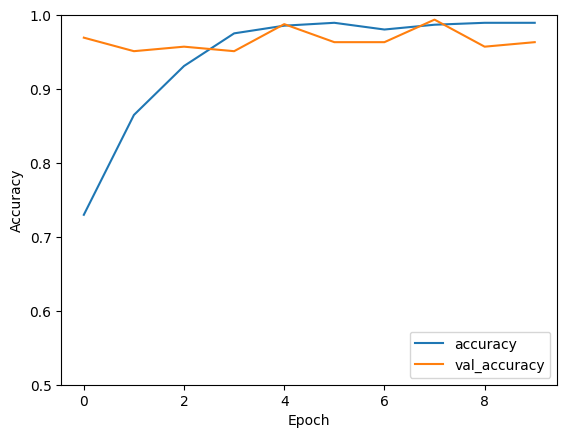

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_dataset, verbose=2)

Result take away: the model does very well identifying SZ identified clusters and the negatives, but is not able to identify the optically selected clusters: in other words, the optical clusters don't look like the SZ clusters. This is obviously true when considering the SZ images only but we had hoped including the optical images for the SZ identified clusters would allow the cnn to identify optically detected clusters


In [48]:

remainder_act = act[125:]
remainder_des = redmapper[125:]
remainder_randoms = neg_im[250:]

des_labels = np.array([1]*remainder_des.shape[0])
act_labels = np.array([1]*remainder_act.shape[0])
randoms_labels = np.array([0]*remainder_randoms.shape[0])

act_loss, act_acc = model.evaluate(x = remainder_act, y = act_labels, verbose=2)
des_loss, des_acc = model.evaluate(x = remainder_des, y = des_labels, verbose=2)
randoms_loss, randoms_acc = model.evaluate(x = remainder_randoms, y = randoms_labels, verbose=2)


194/194 - 0s - loss: 0.1581 - accuracy: 0.9691
285/285 - 1s - loss: 2.1841 - accuracy: 0.4351
38/38 - 0s - loss: 0.2802 - accuracy: 0.8684


In [ ]:
#Just looking to see if there are any obvious trends
for thing in test_dataset:
    for i in range(thing[1].shape[0]):
        truth = thing[1][i]
        imap = thing[0][i]
        pred = model.predict(np.expand_dims(thing[0][i], axis = 0))
        print(truth.numpy(), np.argmax(tf.nn.softmax(pred)[0]), 100*np.max(tf.nn.softmax(pred)[0]))
        plt.imshow(imap[...,5])
        plt.show()
        plt.close()
        plt.imshow(np.log(np.abs(imap[...,2])))
        plt.show()
        plt.close()

In [ ]:
for i in range(redmapper.shape[0]):
    truth = 1
    imap = redmapper[i]
    pred = model.predict(np.expand_dims(redmapper[i], axis = 0))
    print(truth, np.argmax(tf.nn.softmax(pred)[0]), 100*np.max(tf.nn.softmax(pred)[0]))
    plt.imshow(imap[...,1])
    plt.show()
    plt.close()

# Redmapper only

In [69]:
#Trying to learn what optically selected clusters look like in the sz and optical, no SZ clusters included 

h5f_des = h5py.File('/gpfs/fs0/project/r/rbond/jorlo/datasets/ml-clusters/des/full_des_1000_w_y.h5','r')
h5f_random = h5py.File('/gpfs/fs0/project/r/rbond/jorlo/datasets/ml-clusters/random/full_random_1000_w_y.h5','r')
h5f_act = h5py.File('/gpfs/fs0/project/r/rbond/jorlo/datasets/ml-clusters/act/full_act_1000_w_y.h5','r')


pos_im_1 = h5f_des['des'][:]
neg_im = h5f_random['random'][:]
pos_im_2 = h5f_act['act'][:]

pos_im = np.concatenate((pos_im_1, pos_im_2))

flags = []
for i in range(pos_im.shape[0]):
    if np.any(np.isnan(pos_im[i,...])):
        flags.append(i)

pos_im = np.delete(pos_im, flags, axis = 0)        

flags = []
for i in range(neg_im.shape[0]):
    if np.any(np.isnan(neg_im[i,...])):
        flags.append(i)

neg_im = np.delete(neg_im, flags, axis = 0)   


neg_im = neg_im[:len(pos_im)]
pos_im = pos_im[:len(neg_im)]

print(len(pos_im), len(neg_im))


#pos_im, neg_im = pos_im[...,:5], neg_im[...,:5]

922 922


In [ ]:
i = 2

plt.imshow(neg_im[i,...,5])
plt.title('Negative in y')
plt.show()
plt.close()


plt.imshow(np.log(np.abs(neg_im[i,...,1])))
plt.title('Positive in Optical, r band')
plt.show()
plt.close()

j = 2
plt.imshow(pos_im[j,...,5])
plt.title('Positive in y')
plt.show()
plt.close()


plt.imshow(np.log(np.abs(pos_im[j,...,1])))
plt.title('Positive in Optical, r band')
plt.show()
plt.close()


In [135]:
#pos_im, neg_im = pos_im[...,3:], neg_im[...,3:]
np.std(pos_im[0,...,0])

1.0000000000000002

In [136]:
tot = min(pos_im.shape[0], neg_im.shape[0])
train_size = int(0.7 * tot)
val_size = int(0.15 * tot)
test_size = int(0.15 * tot)
    
train_pos = pos_im[:train_size]
val_pos = pos_im[train_size:train_size + val_size]
test_pos = pos_im[train_size + val_size:]
    
train_neg = neg_im[:train_size]
val_neg = neg_im[train_size:train_size + val_size]
test_neg = neg_im[train_size + val_size:]

input_shape = train_pos.shape[1:]



In [137]:
print(train_pos.shape, train_neg.shape)
print(input_shape)

(645, 399, 399, 6) (645, 399, 399, 6)
(399, 399, 6)


In [138]:
train_images = np.concatenate((train_pos,train_neg))
val_images = np.concatenate((val_pos,val_neg))
test_images = np.concatenate((test_pos,test_neg))

train_labels = np.array(train_pos.shape[0]*[1] + train_neg.shape[0]*[0])
val_labels = np.array(val_pos.shape[0]*[1] + val_neg.shape[0]*[0])
test_labels = np.array(test_pos.shape[0]*[1] + test_neg.shape[0]*[0])

In [139]:
batch_size = 10

#data_augmentation = tf.keras.Sequential(
#    [
#        tf.keras.preprocessing.image.RandomFlip("horizontal"),
#        tf.keras.preprocessing.RandomRotation(0.1),
#        tf.keras.preprocessing.RandomZoom(0.1),
#        tf.keras.preprocessing.image.random_shift(0.01, 0.01),
#    ]
#)

data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360, width_shift_range=4,
    height_shift_range=4,zoom_range=0.3)

def prepare(ds, shuffle=False, augment=False):

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), )

  # Use buffered prefecting on all datasets
  return ds

In [140]:
batch_size = 10

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)

In [141]:
model = make_model('kosiba', input_shape = input_shape, degree = 5)


data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360, width_shift_range=4,
    height_shift_range=4,zoom_range=0.3)


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 397, 397, 64)      3520      
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 198, 198, 64)      0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 196, 196, 32)      18464     
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 46, 46, 32)      

In [142]:
#history = model.fit(data_augmentation.flow(train_images, train_labels), epochs=20, 
#                    validation_data=val_dataset)

history = model.fit(train_dataset, epochs=10, 
                    validation_data=val_dataset)

Train for 129 steps, validate for 28 steps
Epoch 1/10
129/129 [==============================] - 8s 60ms/step - loss: 1.0702 - accuracy: 0.7550 - val_loss: 0.8685 - val_accuracy: 0.9891
Epoch 2/10
129/129 [==============================] - 7s 56ms/step - loss: 0.9664 - accuracy: 0.8341 - val_loss: 0.7116 - val_accuracy: 0.9819
Epoch 3/10
129/129 [==============================] - 7s 54ms/step - loss: 0.9201 - accuracy: 0.8465 - val_loss: 0.7054 - val_accuracy: 0.9674
Epoch 4/10
129/129 [==============================] - 7s 54ms/step - loss: 0.8622 - accuracy: 0.8605 - val_loss: 0.6581 - val_accuracy: 0.9493
Epoch 5/10
129/129 [==============================] - 7s 58ms/step - loss: 0.8046 - accuracy: 0.8930 - val_loss: 0.6662 - val_accuracy: 0.9565
Epoch 6/10
129/129 [==============================] - 7s 56ms/step - loss: 0.6825 - accuracy: 0.9341 - val_loss: 0.6010 - val_accuracy: 0.9710
Epoch 7/10
129/129 [==============================] - 9s 73ms/step - loss: 0.6827 - accuracy: 0.926

28/28 - 1s - loss: 0.5551 - accuracy: 0.9640


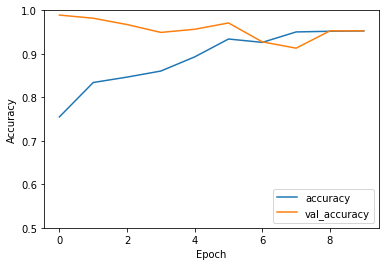

In [143]:
#Promising but looks like it needs more training

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_dataset, verbose=2)

At this point we needed to run things longer (a few hours) than you could do in a notebook. I also added image augmentation. The script in which we did that is large-redmapper-with-aug.py in this github. The results were save and loaded below.

# Many Epochs with Data Aug

This is what's loaded in the pretrained model below. You can try to run it here but it generally takes >1h so rude to do on an interactive node

In [ ]:
pos_im_act = []
path = "/mnt/welch/USERS/jorlo/ml-clusters/"
#for directory in os.listdir(path+'act/'):
#    print(directory)
#    h5f = h5py.File(path+'act/'+directory)
#    pos_im_act.append(h5f['act'][:])
    
#pos_im_act = np.vstack(pos_im_act)
    
pos_im_des = []
path = "/mnt/welch/USERS/jorlo/ml-clusters/"
for directory in os.listdir(path+'des/'):
    print(directory)
    h5f = h5py.File(path+'des/'+directory)
    pos_im_des.append(h5f['des'][:])
    
pos_im_des = np.vstack(pos_im_des)

neg_im = []
path = "/mnt/welch/USERS/jorlo/ml-clusters/"
for directory in os.listdir(path+'random/'):
    print(directory)
    h5f = h5py.File(path+'random/'+directory)
    neg_im.append(h5f['random'][:])
    
neg_im = np.vstack(neg_im)

#pos_im = pos_im_act
pos_im = pos_im_des
#pos_im = np.concatenate((pos_im_act, pos_im_des))


des_0000_w_y.h5
des_4000_w_y.h5
des_5000_w_y.h5
des_3000_w_y.h5
des_2000_w_y.h5
des_1000_w_y.h5
des_6000_w_y.h5
random_6000_w_y.h5
random_5000_w_y.h5
random_2000_w_y.h5
random_0000_w_y.h5
random_3000_w_y.h5
random_7000_w_y.h5


In [ ]:
#pos_im = pos_im_des
neg_im.shape

In [ ]:
flags = []
for i in range(pos_im.shape[0]):
        if np.any(np.isnan(pos_im[i,...])):
                flags.append(i)

pos_im = np.delete(pos_im, flags, axis = 0)

flags = []
for i in range(neg_im.shape[0]):
        if np.any(np.isnan(neg_im[i,...])):
                flags.append(i)

neg_im = np.delete(neg_im, flags, axis = 0)


neg_im = neg_im[:len(pos_im)]
pos_im = pos_im[:len(neg_im)]

cut = 3000

neg_im = neg_im[:cut]
pos_im = pos_im[:cut]
print(len(pos_im), len(neg_im))


In [ ]:
w_y = 'False'

if w_y == 'False':
        print('No y')
        pos_im, neg_im = pos_im[...,:5], neg_im[...,:5]

tot = min(pos_im.shape[0], neg_im.shape[0])
train_size = int(0.7 * tot)
val_size = int(0.15 * tot)
test_size = int(0.15 * tot)

train_pos = pos_im[:train_size]
val_pos = pos_im[train_size:train_size + val_size]
test_pos = pos_im[train_size + val_size:]

train_neg = neg_im[:train_size]
val_neg = neg_im[train_size:train_size + val_size]
test_neg = neg_im[train_size + val_size:]

input_shape = train_pos.shape[1:]

train_images = np.concatenate((train_pos,train_neg))
val_images = np.concatenate((val_pos,val_neg))
test_images = np.concatenate((test_pos,test_neg))

train_labels = np.array(train_pos.shape[0]*[1] + train_neg.shape[0]*[0])
val_labels = np.array(val_pos.shape[0]*[1] + val_neg.shape[0]*[0])
test_labels = np.array(test_pos.shape[0]*[1] + test_neg.shape[0]*[0])

batch_size = 10

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)

model = make_model('kosiba', input_shape = input_shape, degree = 4)


In [ ]:
data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360, width_shift_range=4,
    height_shift_range=4,zoom_range=0.3)


In [ ]:
history = model.fit(data_augmentation.flow(train_images, train_labels), epochs=int(20),
                    validation_data=val_dataset)


In [ ]:

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_dataset, verbose=2)

# Pretrained Redmapper

In [61]:
#pos_im = pk.load(open('/gpfs/fs0/project/r/rbond/jorlo/datasets/cluster-test/large-redmapper/large-redmapper_w_y.pk', 'rb'))
#pos_im = pk.load(open('/gpfs/fs0/project/r/rbond/jorlo/datasets/cluster-test/large-act/large-act_w_y.pk', 'rb'))
#neg_im = pk.load(open('/gpfs/fs0/project/r/rbond/jorlo/datasets/cluster-test/large-randoms/large-randoms_w_y.pk', 'rb'))


h5f_des = h5py.File('/gpfs/fs0/project/r/rbond/jorlo/datasets/ml-clusters/des/full_des_1000_w_y.h5','r')
h5f_random = h5py.File('/gpfs/fs0/project/r/rbond/jorlo/datasets/ml-clusters/random/full_random_1000_w_y.h5','r')
h5f_act = h5py.File('/gpfs/fs0/project/r/rbond/jorlo/datasets/ml-clusters/act/full_act_1000_w_y.h5','r')


pos_im_1 = h5f_des['des'][:]
neg_im = h5f_random['random'][:]
pos_im_2 = h5f_act['act'][:]

pos_im = np.concatenate((pos_im_1, pos_im_2))


flags = []
for i in range(pos_im.shape[0]):
    if np.any(np.isnan(pos_im[i,...])):
        flags.append(i)

pos_im = np.delete(pos_im, flags, axis = 0)        

flags = []
for i in range(neg_im.shape[0]):
    if np.any(np.isnan(neg_im[i,...])):
        flags.append(i)

neg_im = np.delete(neg_im, flags, axis = 0)   


neg_im = neg_im[:len(pos_im)]
pos_im = pos_im[:len(neg_im)]

print(len(pos_im), len(neg_im))

pos_im, neg_im = pos_im[...,:5], neg_im[...,:5]

red_pos = h5f_des['des'][:]
red_neg = h5f_random['random'][:]

flags = []
for i in range(red_pos.shape[0]):
    if np.any(np.isnan(red_pos[i,...])):
        flags.append(i)

red_pos = np.delete(red_pos, flags, axis = 0)        

flags = []
for i in range(red_neg.shape[0]):
    if np.any(np.isnan(red_neg[i,...])):
        flags.append(i)

red_neg = np.delete(red_neg, flags, axis = 0)   


red_neg = red_neg[:len(red_pos)]
red_pos = red_pos[:len(red_neg)]

print(len(red_pos), len(red_neg))

red_pos, red_neg = red_pos[...,:5], red_neg[...,:5]

922 922
351 351


In [62]:
tot = min(pos_im.shape[0], neg_im.shape[0])
train_size = int(0.7 * tot)
val_size = int(0.15 * tot)
test_size = int(0.15 * tot)
    
train_pos = pos_im[:train_size]
val_pos = pos_im[train_size:train_size + val_size]
test_pos = pos_im[train_size + val_size:]
    
train_neg = neg_im[:train_size]
val_neg = neg_im[train_size:train_size + val_size]
test_neg = neg_im[train_size + val_size:]

input_shape = train_pos.shape[1:]

red_tot = tot = min(red_pos.shape[0], neg_red.shape[0])

red_train_size = int(0.7 * red_tot)
red_val_size = int(0.15 * red_tot)
red_test_size = int(0.15 * red_tot)

red_test_pos = red_pos[red_train_size + red_val_size:]
red_test_neg = red_neg[red_train_size + red_val_size:]


In [63]:
red_tot

351

In [64]:
train_images = np.concatenate((train_pos,train_neg))
val_images = np.concatenate((val_pos,val_neg))
test_images = np.concatenate((test_pos,test_neg))
red_test_images = np.concatenate((red_test_pos, red_test_neg))

train_labels = np.array(train_pos.shape[0]*[1] + train_neg.shape[0]*[0])
val_labels = np.array(val_pos.shape[0]*[1] + val_neg.shape[0]*[0])
test_labels = np.array(test_pos.shape[0]*[1] + test_neg.shape[0]*[0])
red_test_labels = np.array(red_test_pos.shape[0]*[1] + red_test_neg.shape[0]*[0])

In [65]:
model = make_model('kosiba', input_shape = input_shape, degree = 4)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 397, 397, 64)      2944      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 198, 198, 64)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 196, 196, 32)      18464     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 46, 46, 32)       

In [66]:
#This model was trained only on redmapper clusters
checkpoint_path = "/scratch/r/rbond/jorlo/ml-clusters/models/redmapper_wo_y.ckpt"
model.load_weights(checkpoint_path)

In [67]:
#The accuracy sadly isn't that much better than above but 81% is getting somewhere
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
loss, acc = model.evaluate(red_test_images, red_test_labels, verbose=2)


278/278 - 1s - loss: 2.7835 - accuracy: 0.8129
108/108 - 0s - loss: 1.8242 - accuracy: 0.9444


In [53]:
#Do we do better including the y?
checkpoint_path = "/scratch/r/rbond/jorlo/ml-clusters/models/redmapper_w_y.ckpt"
model.load_weights(checkpoint_path)

loss, acc = model.evaluate(test_images, test_labels, verbose=2)
loss, acc = model.evaluate(red_test_images, red_test_labels, verbose=2)


278/278 - 1s - loss: 3.2902 - accuracy: 0.8453
388/388 - 1s - loss: 8.2477 - accuracy: 0.5954


In [ ]:
for thing in test_dataset:
    for i in range(thing[1].shape[0]):
        truth = thing[1][i]
        imap = thing[0][i]
        pred = model.predict(np.expand_dims(thing[0][i], axis = 0))
        print(truth.numpy(), np.argmax(tf.nn.softmax(pred)[0]), 100*np.max(tf.nn.softmax(pred)[0]))
        plt.imshow(imap[...,5])
        plt.show()
        plt.close()
        plt.imshow(np.log(np.abs(imap[...,2])))
        plt.show()
        plt.close()

There was concern that the model was only using the SZ info and nothing from the optical, so I manually set the SZ weights to zero

In [83]:

for layer in model.layers:
    if layer.name[0:6] == 'conv2d':
        temp = layer.get_weights()
        temp[0][...,:5,:] = np.zeros(temp[0][...,:5,:].shape)
        layer.set_weights(temp)

In [84]:

loss, acc_test = model.evaluate(test_images, test_labels, verbose=2)
loss, acc_val = model.evaluate(val_images, val_labels, verbose=2)
loss, acc_train = model.evaluate(train_images, train_labels, verbose=2)


69/69 - 0s - loss: 4.0786 - accuracy: 0.4638
28/28 - 0s - loss: 3.0478 - accuracy: 0.6429
138/138 - 0s - loss: 2.9386 - accuracy: 0.6304


SZ is definitely driving the accuracy here but it does seem like optical is doing something? At this point we needed a larger data set, so I got to making images of all the clusters, which is what's going on in full_stamper.py. We now have about 6000 clusters and as many negatives to train on, but I just haven't had the time to actually run it yet, which is basically where the project stands

In [28]:
act_bad.shape

(807, 399, 399, 6)

In [29]:
act_good.shape

(103, 399, 399, 6)

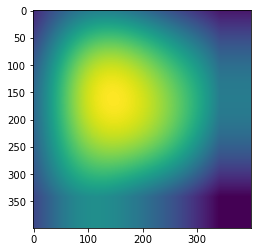

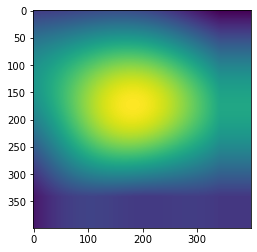

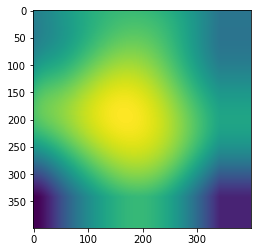

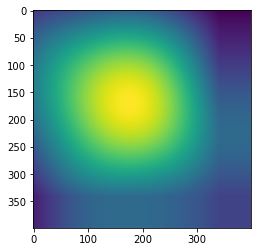

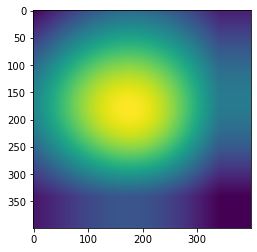

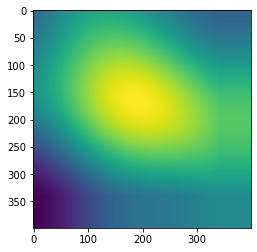

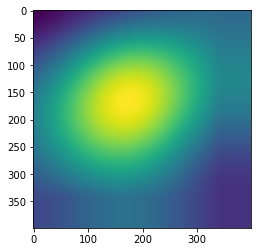

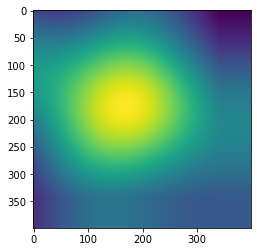

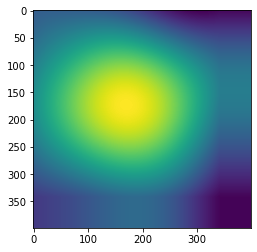

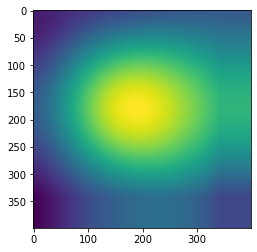

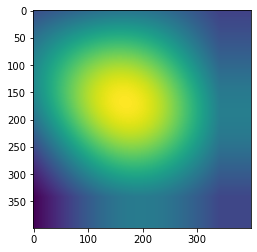

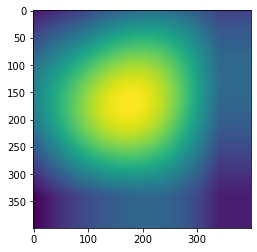

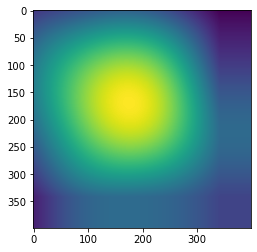

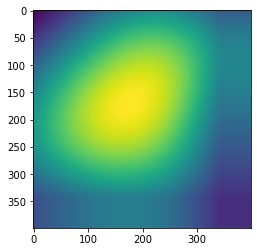

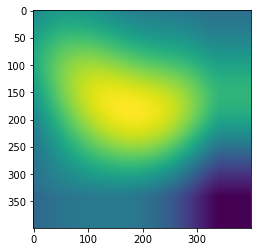

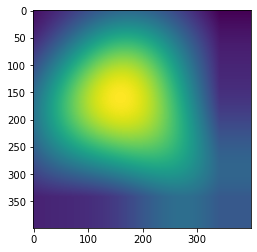

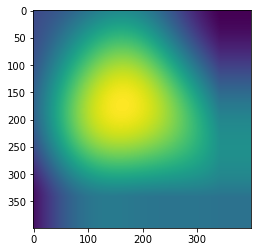

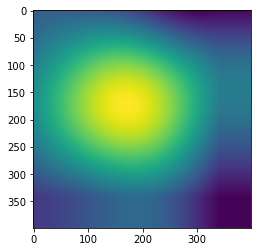

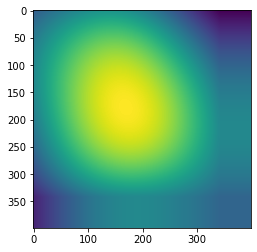

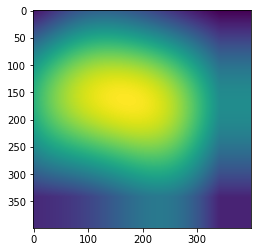

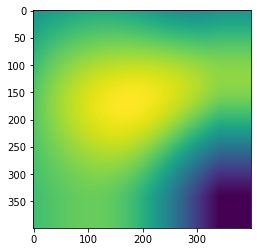

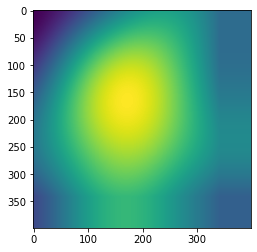

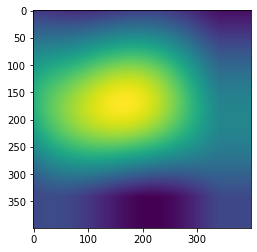

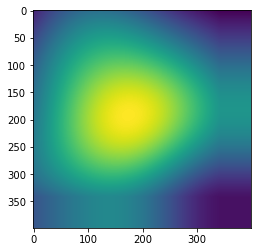

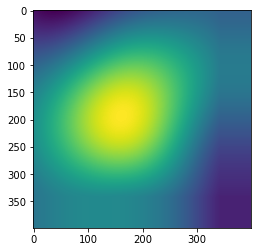

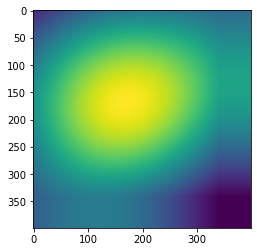

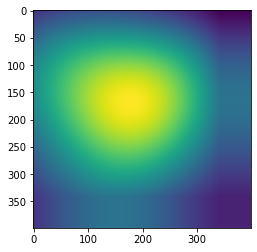

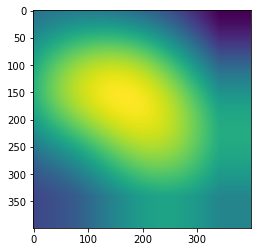

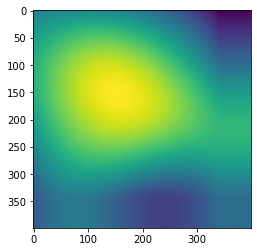

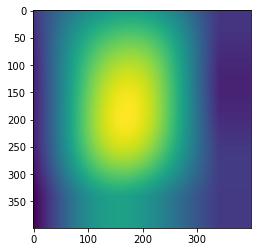

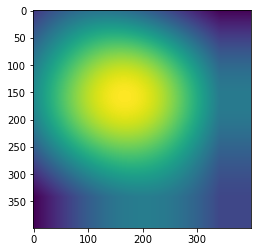

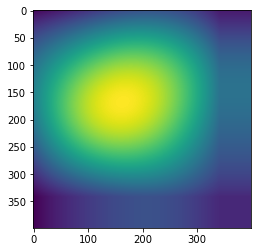

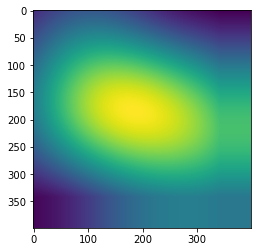

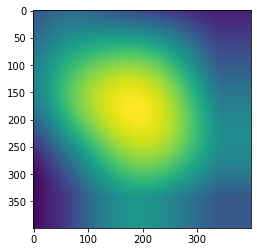

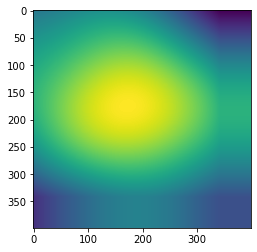

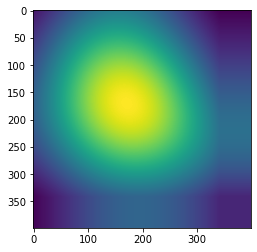

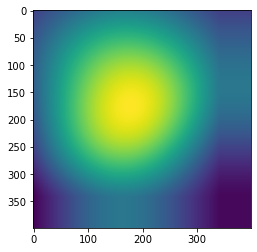

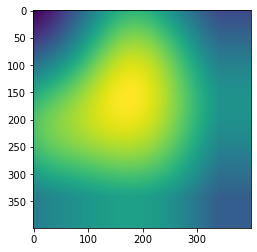

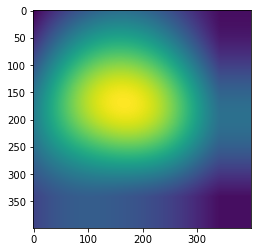

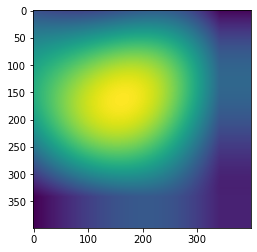

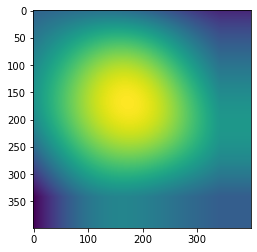

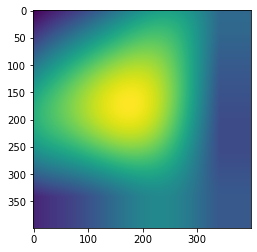

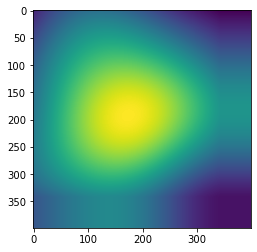

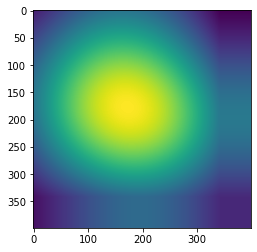

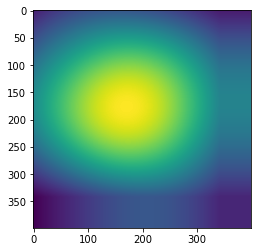

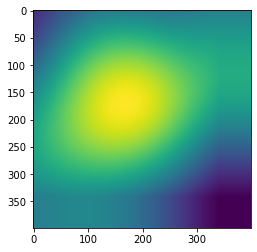

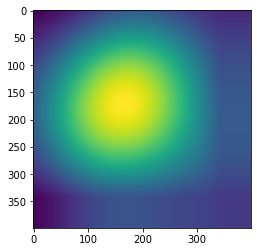

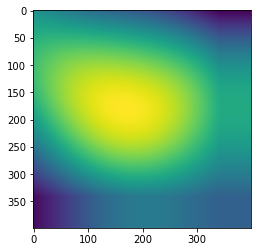

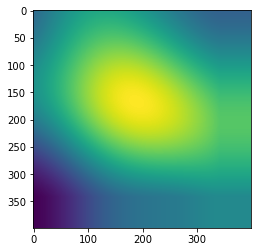

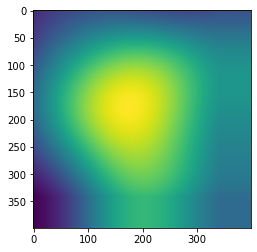

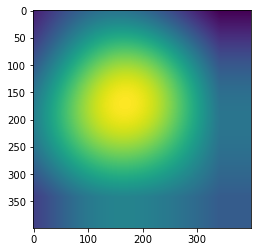

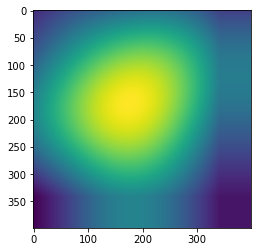

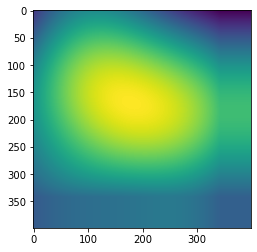

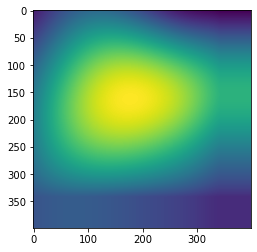

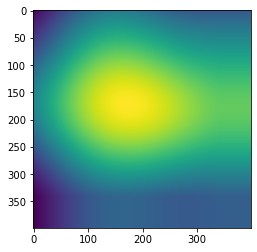

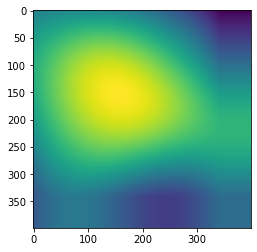

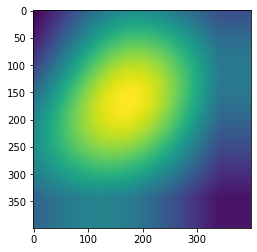

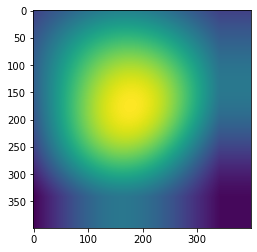

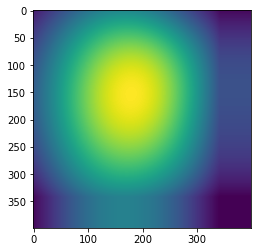

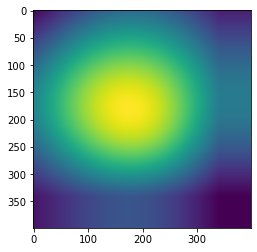

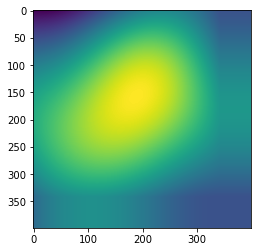

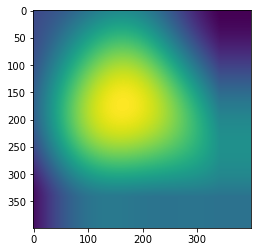

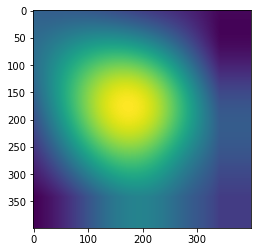

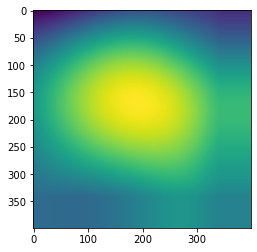

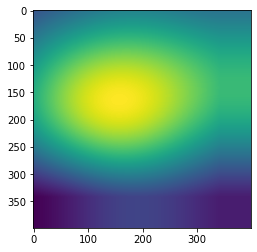

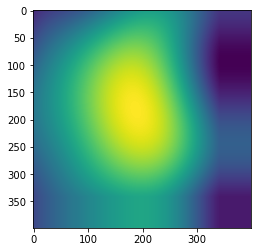

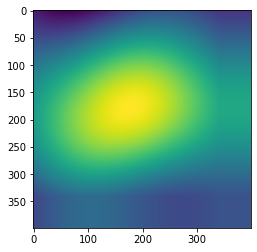

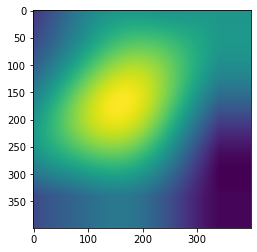

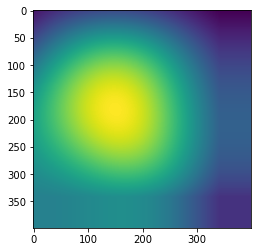

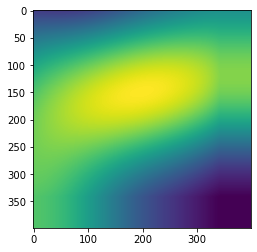

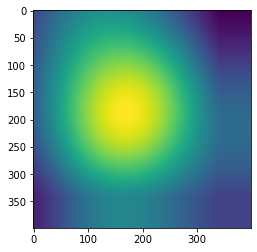

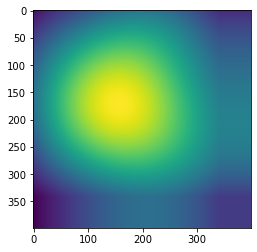

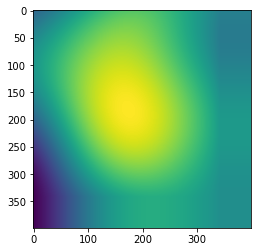

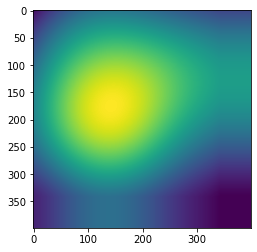

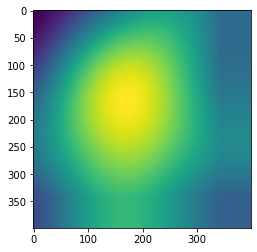

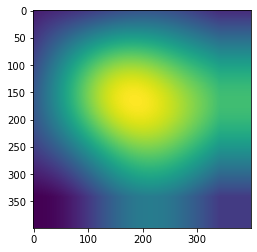

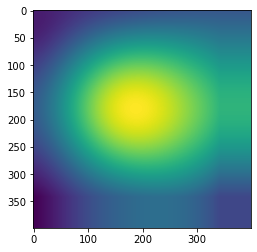

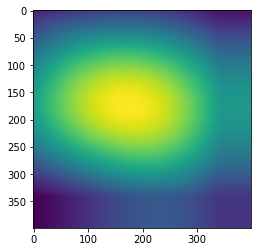

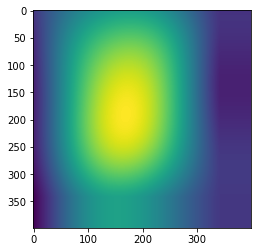

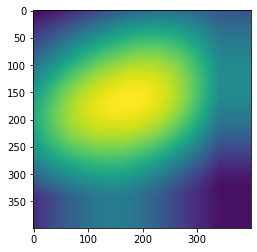

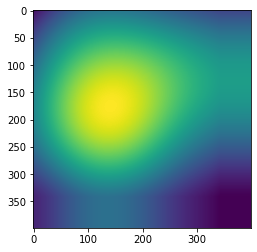

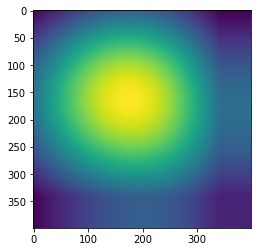

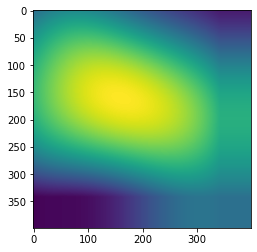

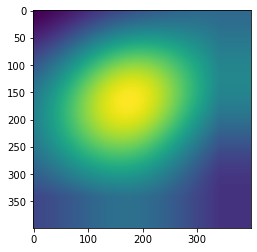

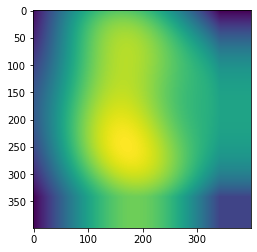

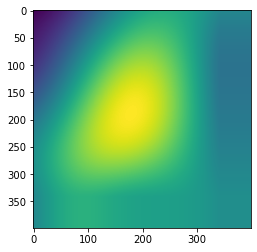

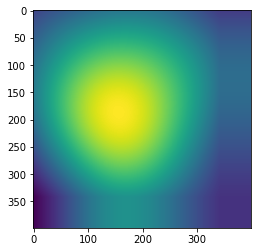

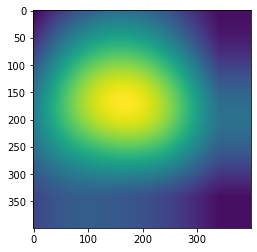

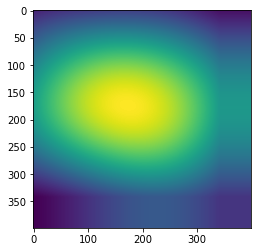

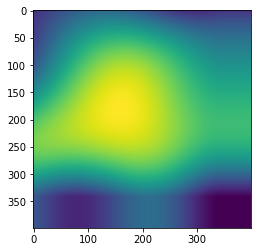

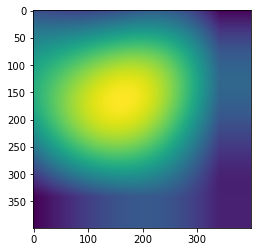

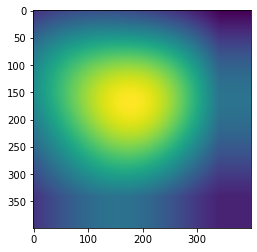

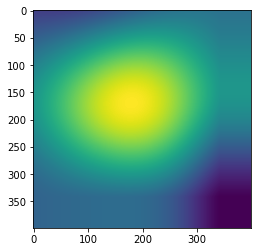

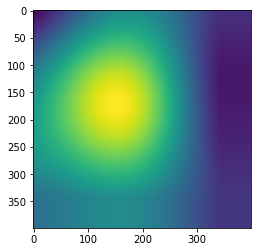

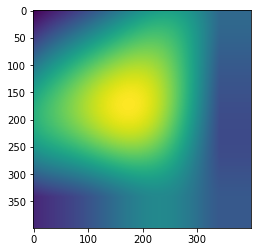

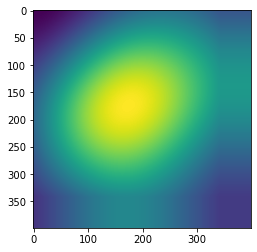

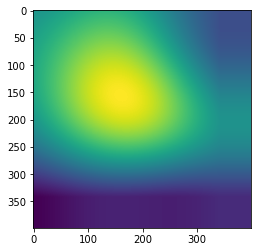

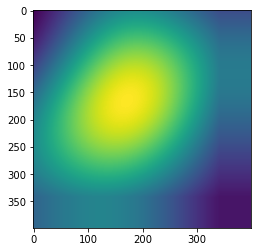

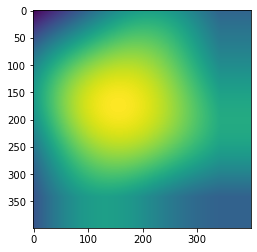

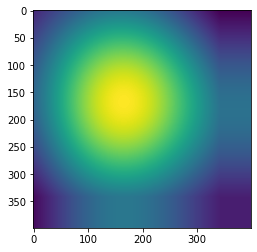

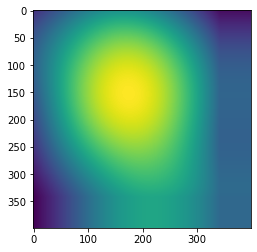

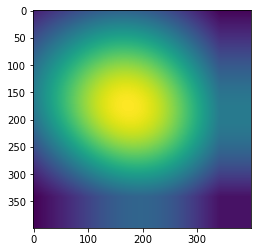

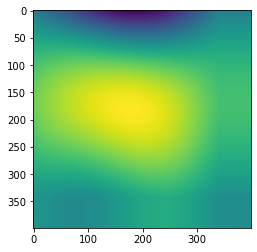

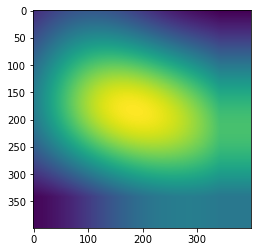

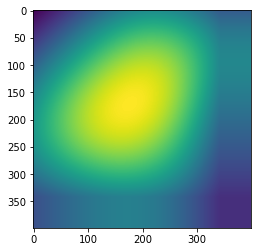

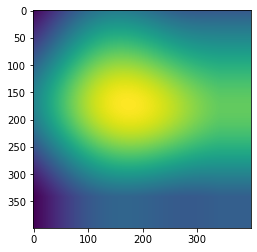

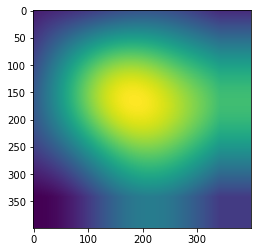

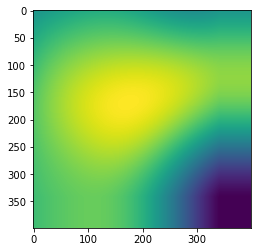

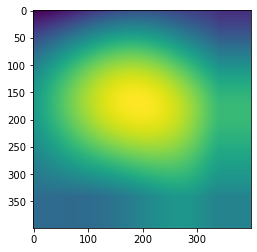

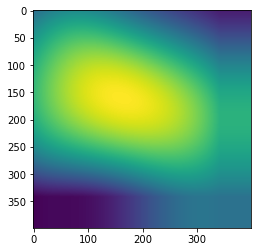

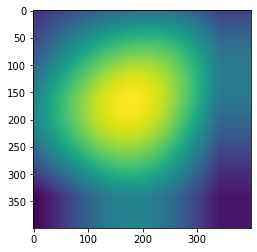

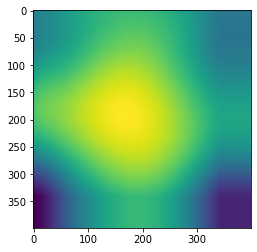

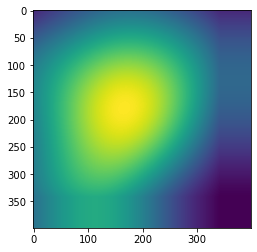

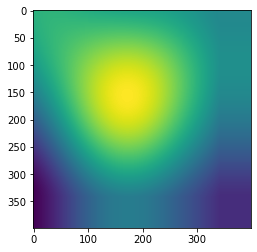

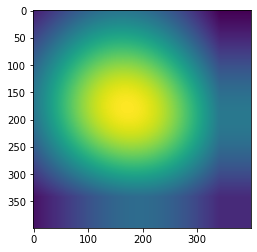

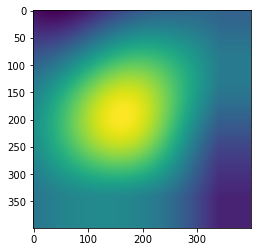

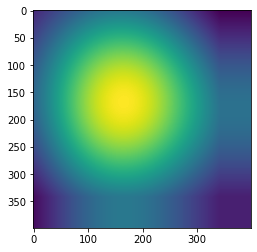

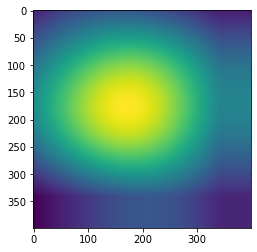

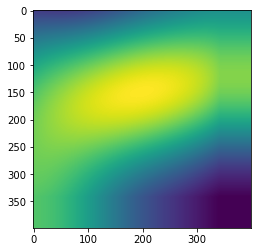

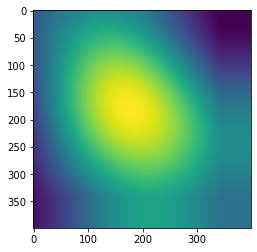

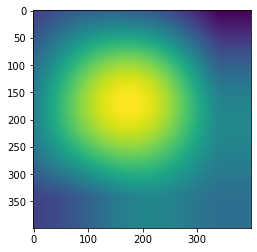

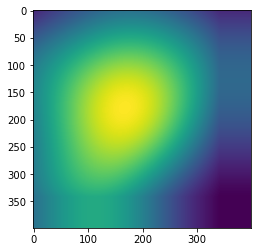

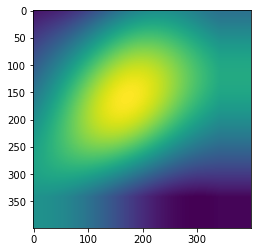

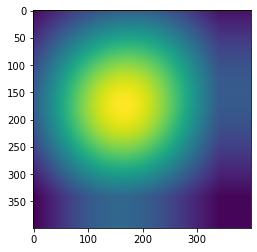

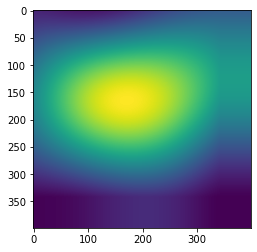

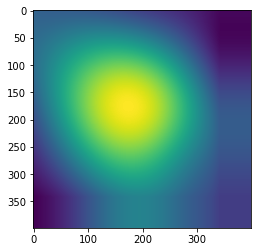

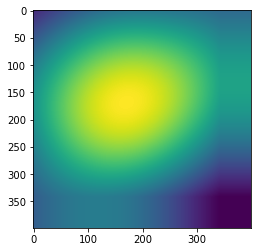

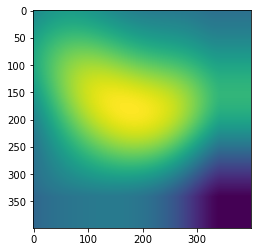

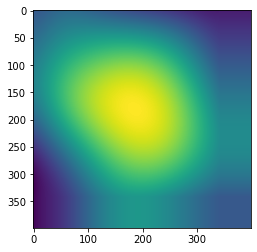

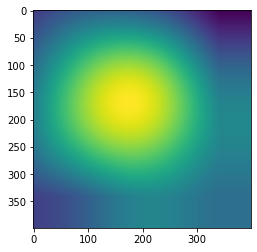

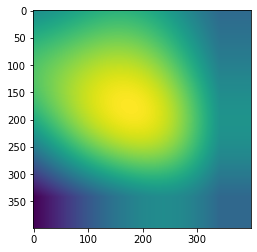

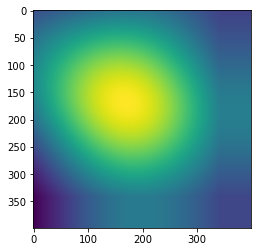

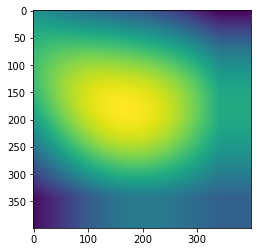

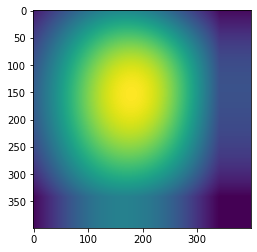

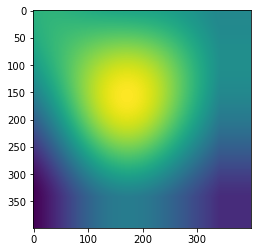

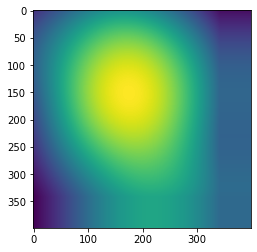

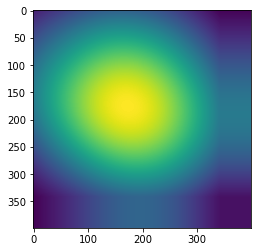

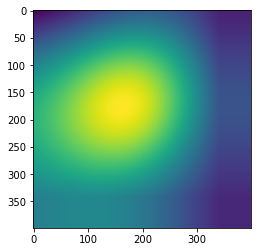

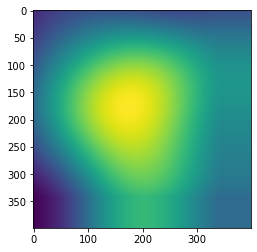

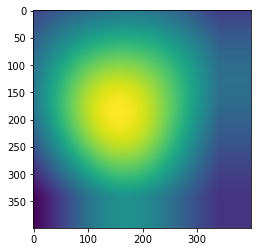

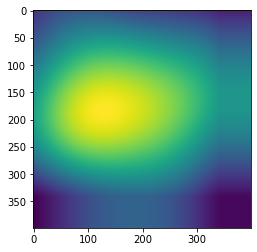

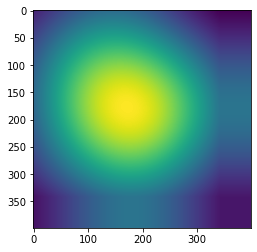

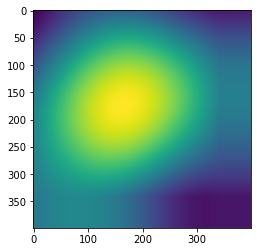

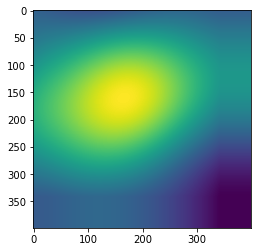

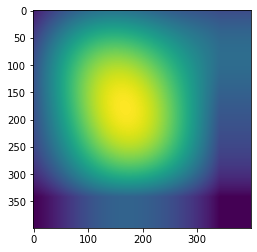

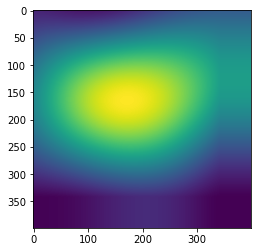

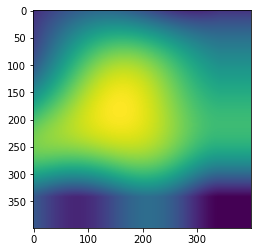

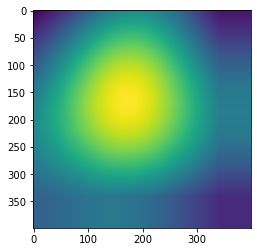

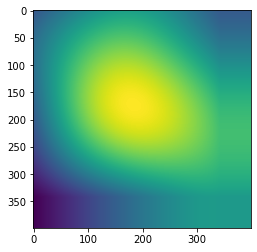

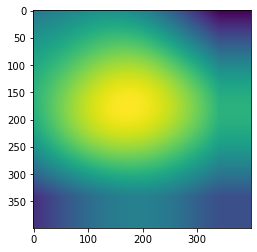

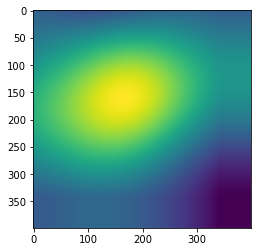

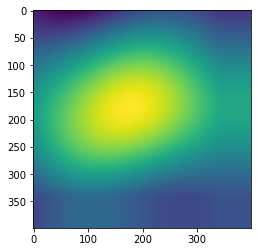

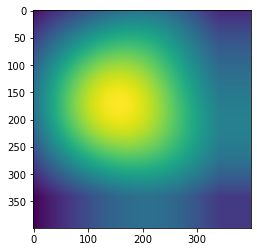

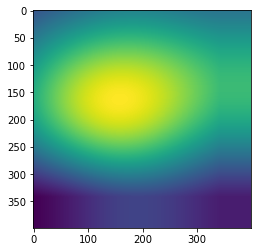

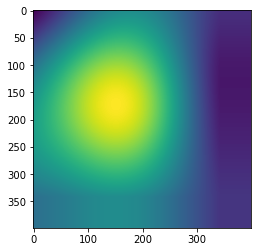

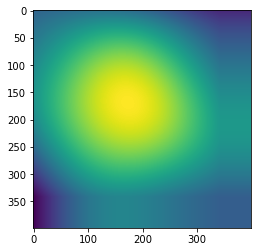

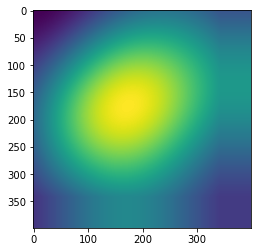

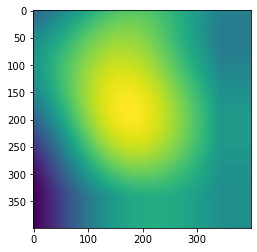

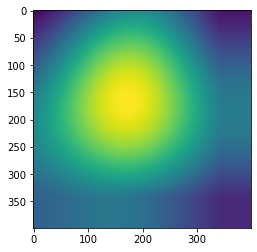

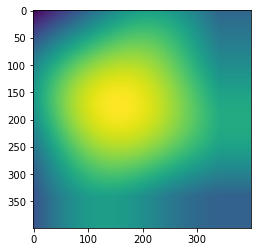

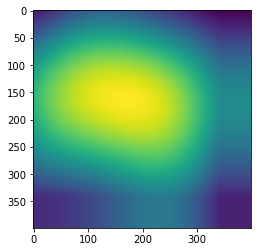

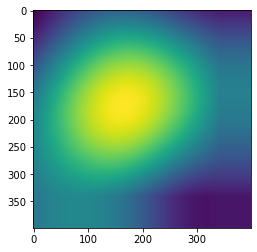

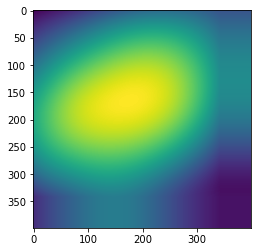

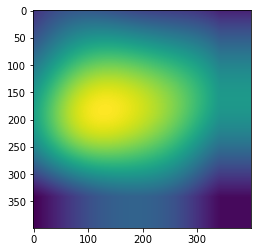

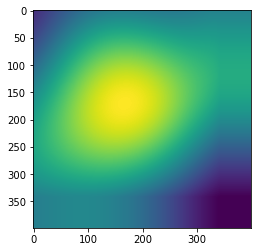

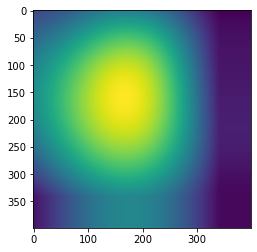

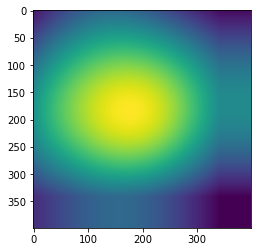

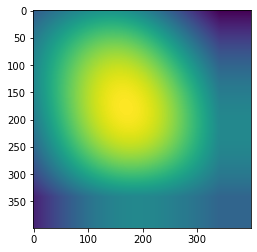

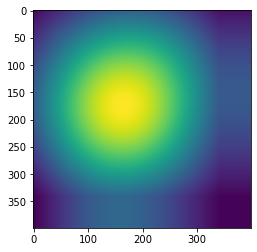

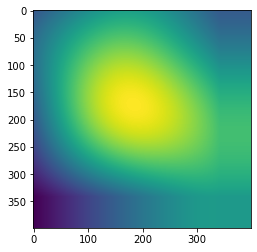

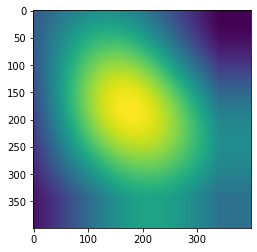

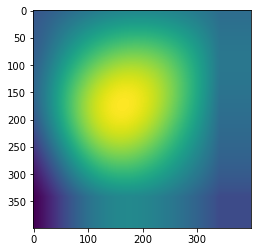

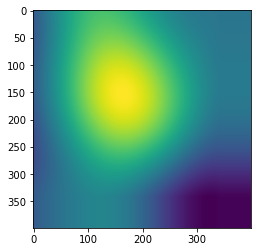

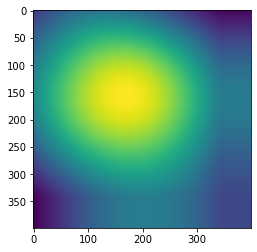

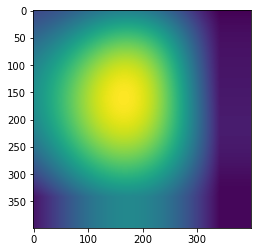

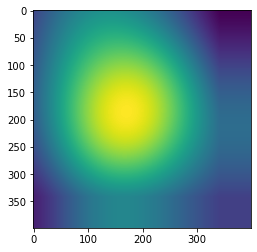

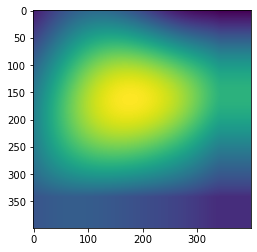

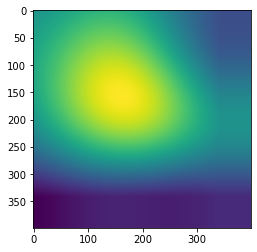

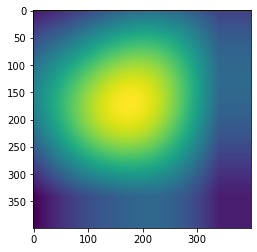

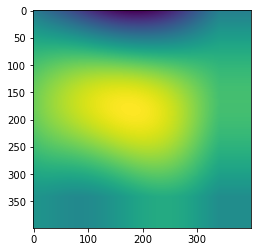

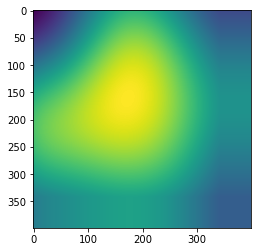

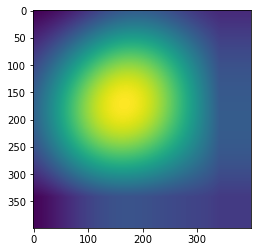

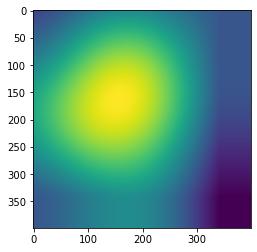

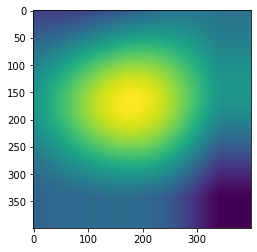

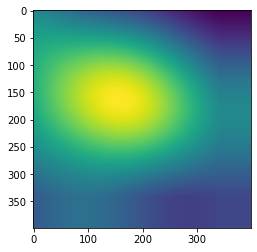

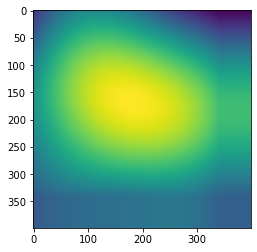

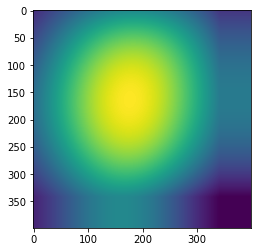

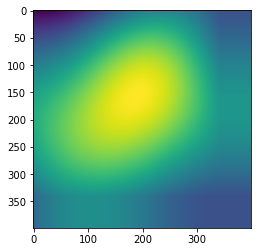

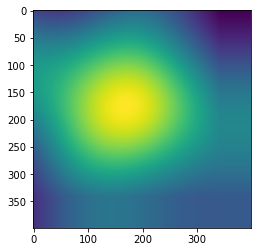

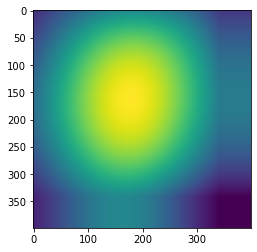

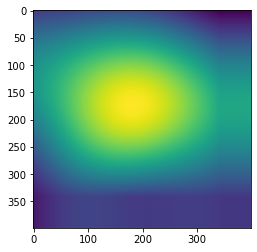

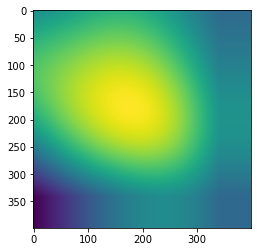

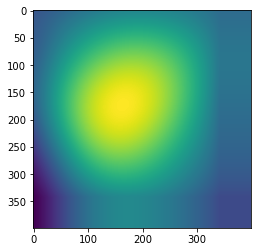

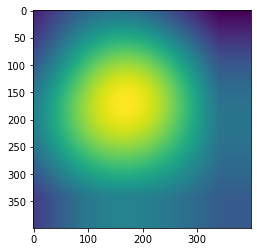

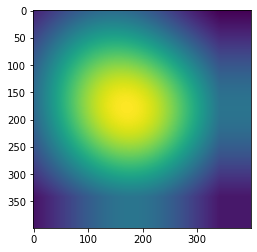

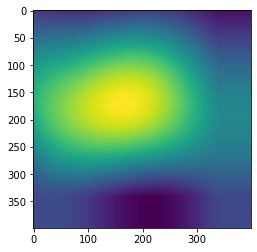

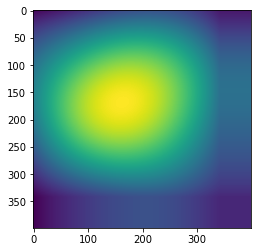

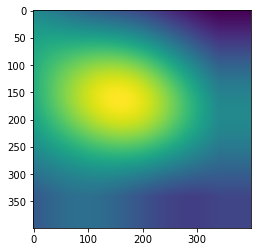

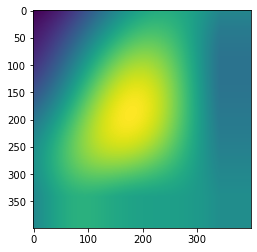

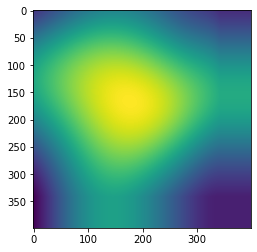

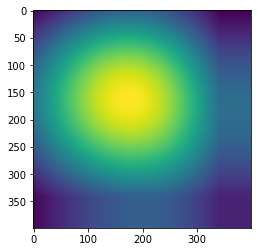

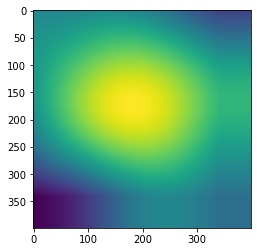

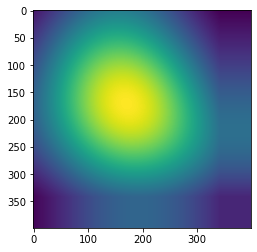

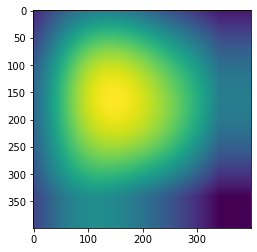

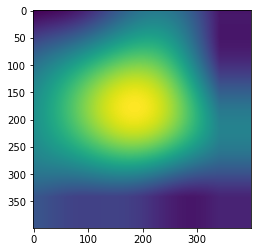

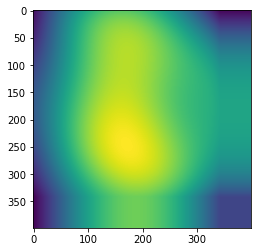

In [58]:
for i in range(act_good.shape[0]):
    plt.imshow(act_good[i,...,5])
    plt.show()
    plt.close()
    plt.imshow(act[i,...,5])
    plt.show()
    plt.close()


# Testing Region Proposal

In [2]:
import cv2

def selective_search(image, method=None):

    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    # check to see if we are using the *fast* but *less accurate* version
    # of selective search
    if method == "fast":
        ss.switchToSelectiveSearchFast()
    # otherwise we are using the *slower* but *more accurate* version
    else:
        ss.switchToSelectiveSearchQuality()
    # run selective search on the input image
    rects = ss.process()
    # return the region proposal bounding boxes
    return rects

In [10]:
pos_im = act

im = pos_im[5,...,-1]

rects = selective_search(im.astype('float32'))

error: OpenCV(4.5.5) ../modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<3>; VDepth = cv::impl::{anonymous}::Set<0, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = (cv::impl::<unnamed>::SizePolicy)2; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [9]:
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut[...,5])


IndexError: index 5 is out of bounds for axis 2 with size 4

In [8]:
des_catalog = fits.open('/home/r/rbond/jorlo/dev/ML-clusters/data/des/redmapper_y1a1_public_v6.4_catalog.fits')
ras, decs = des_catalog[1].data['RA'], des_catalog[1].data['dec']

... WCS set-up took 63.056 sec ...


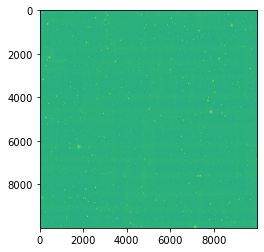

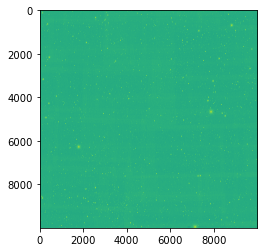

/home/r/rbond/jorlo/.conda/envs/gpu-ml-clusters/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


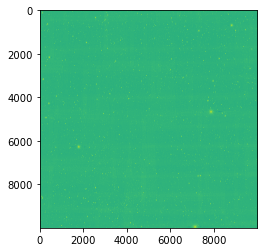

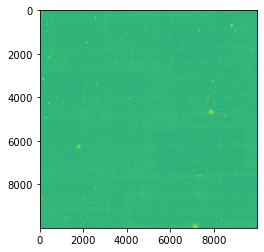

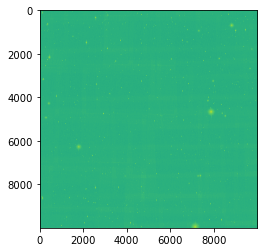

In [57]:
tiler=DESTiler.DESTiler("DES_DR1_TILE_INFO.csv")

names = os.listdir('/project/r/rbond/jorlo/datasets/DESTileImages/')
to_return = []
ra, dec= ras[0], decs[0]

tileName=tiler.getTileName(ra, dec)
for name in names:
    if tileName in name:
        fileName = name[:21]
        break
bands = ['g', 'r', 'i', 'z', 'Y']
for j, band in enumerate(bands):
    hi_data = fits.open('/project/r/rbond/jorlo/datasets/DESTileImages/{}_{}.fits.fz'.format(fileName,band))
    plt.imshow(np.log(np.abs(hi_data[1].data)))
    plt.show()
    plt.close()


In [58]:
header = hi_data[1].header
w = wcs.WCS(header)
hdata = hi_data[1].data


In [59]:
hdata.shape

(10000, 10000)

In [67]:
print(wcs.utils.pixel_to_skycoord(0,0, w))
print(wcs.utils.pixel_to_skycoord(10000,10000, w))

dec,ra = np.deg2rad([wcs.utils.pixel_to_skycoord(5000,5000, w).dec.value,wcs.utils.pixel_to_skycoord(5000,5000, w).ra.value]) 
width = np.deg2rad(np.abs(wcs.utils.pixel_to_skycoord(10000,10000, w).dec.value - wcs.utils.pixel_to_skycoord(0,0, w).dec.value))
box = [[dec-width/2.,ra-width/2.],[dec+width/2.,ra+width/2.]]


smap = enmap.read_fits('/gpfs/fs0/project/r/rbond/jorlo/SZ_map/stitched_Arnaud_M2e14_z0p4_filteredMap.fits', box = box)


AttributeError: 'numpy.int32' object has no attribute 'cpdis1'

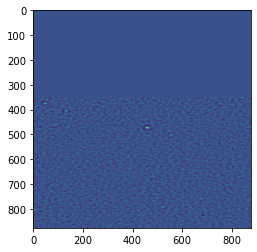

In [63]:
plt.imshow(smap)

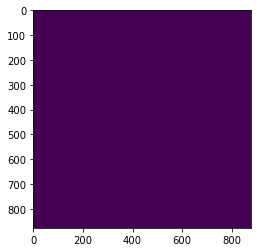

In [64]:
im = np.stack((smap,smap,smap), axis = -1)

rects = selective_search(im.astype('float32'))
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut[...,1])


In [66]:
rects

array([[  0,   0, 877, 877]], dtype=int32)

In [43]:
model = make_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 340, 340, 32)      1472      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 170, 170, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 168, 168, 64)      18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 84, 84, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 82, 82, 64)        36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 430336)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               